<a href="https://colab.research.google.com/github/takbull/U-Tokyo-Deep-Generative-Model-Spring-Seminar/blob/master/UTDGM_2_lecture_chap02_exercise_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第2回講義 演習 GANの実装

In [0]:
import PIL
PIL.PILLOW_VERSION = PIL.__version__

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import grad # double bibun OK!!
from IPython import display
import pylab as pl

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES '] = '0'

## 1. 前準備

### 1.1. データローダー

学習用のデータとして`mnist`、`fashion-mnist`、`cifar10`を使用します。以下でそのためのデータローダを用意します。

In [0]:
def dataloader(dataset, input_size, batch_size, split='train'):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    transform2 = transforms.Compose([transforms.Resize(input_size), transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(3,1,1)), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    
    if dataset == 'mnist':
        data_loader = DataLoader(
            datasets.MNIST('data/mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'fashion-mnist':
        data_loader = DataLoader(
            datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'cifar10':
        data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)

    return data_loader

### 1.2.  初期化の定義

重みの初期値を設定するための関数です。モデル構築の際に使用します。

In [0]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

### 1.3. 学習プロセスの表示のための関数

モデルの学習中に、Lossの推移過程と生成例を表示するための関数です。学習のときに使用します。

In [0]:
def display_process(hist, G, image_frame_dim, sample_z_, fix=True):
    plt.gcf().clear()
        
    fig = plt.figure(figsize=(24, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
        
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']
    
    ax1 = fig.add_subplot(1, 2, 1)

    ax1.plot(x, y1, label='D_loss')
    ax1.plot(x, y2, label='G_loss')

    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Loss')

    ax1.legend(loc=4)
    ax1.grid(True)
    
    samples = G(sample_z_)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2

    for i in range(image_frame_dim*image_frame_dim):
        ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
        if samples[i].shape[2]==3:
            ax.imshow(samples[i])
        else:
            ax.imshow(samples[i][:, :, 0], cmap='gray')

## 2. ネットワークの定義

本章では様々なモデルを実装しますが、基本的に同一のGeneratorとDiscriminatorを使用します。それぞれを下記のように定義します。

### 2.1. Generatorの定義

In [0]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential( #bigger bigger image
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(), #output
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

### 2.2. Discriminatorの定義

In [0]:
class discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), #use Leaky
        )
        self.fc = nn.Sequential( #full connection
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input) #get input and through conv!
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

## 3. 各モデルの学習

- 3.1 GAN
- 3.2 LSGAN
- 3.3 WGAN
- 3.4 WGAN_GP
- 3.5 DRAGAN
- 3.6 EBGAN
- 3.7 BEGAN
- 3.8 SNGAN

GANの研究は盛んに行われており、様々なGANのモデルが提案されています。本章では、その様々なモデルの実装を行います。

### 3.1 GAN

まずは一般的なGANのモデルを実装します。


\begin{aligned} L _ { D } ^ { G A N } & = E [ \log ( D ( x ) ) ] + E [ \log ( 1 - D ( G ( z ) ) ) ] \\ L _ { G } ^ { G A N } & = E [ \log ( D ( G ( z ) ) ) ] \end{aligned}

論文: [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

In [0]:
class GAN(object):
    def __init__(self, dataset='mnist', epoch=1):
        self.epoch = epoch
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10
            

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2)) # 2

        self.G.cuda() #cuda i saw before
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda() #binary cross entoropy loss

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1) #real 1 fake0
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_) #random noize, 
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_) #fake vs real (detection!!!)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step() # start learn
                
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

学習データセットとして、MNIST、Fashion MNIST、Cifar10を使用できます。モデルの引数で利用するデータセットを変更できます。

それぞれのデータセットで学習過程をみてみましょう。

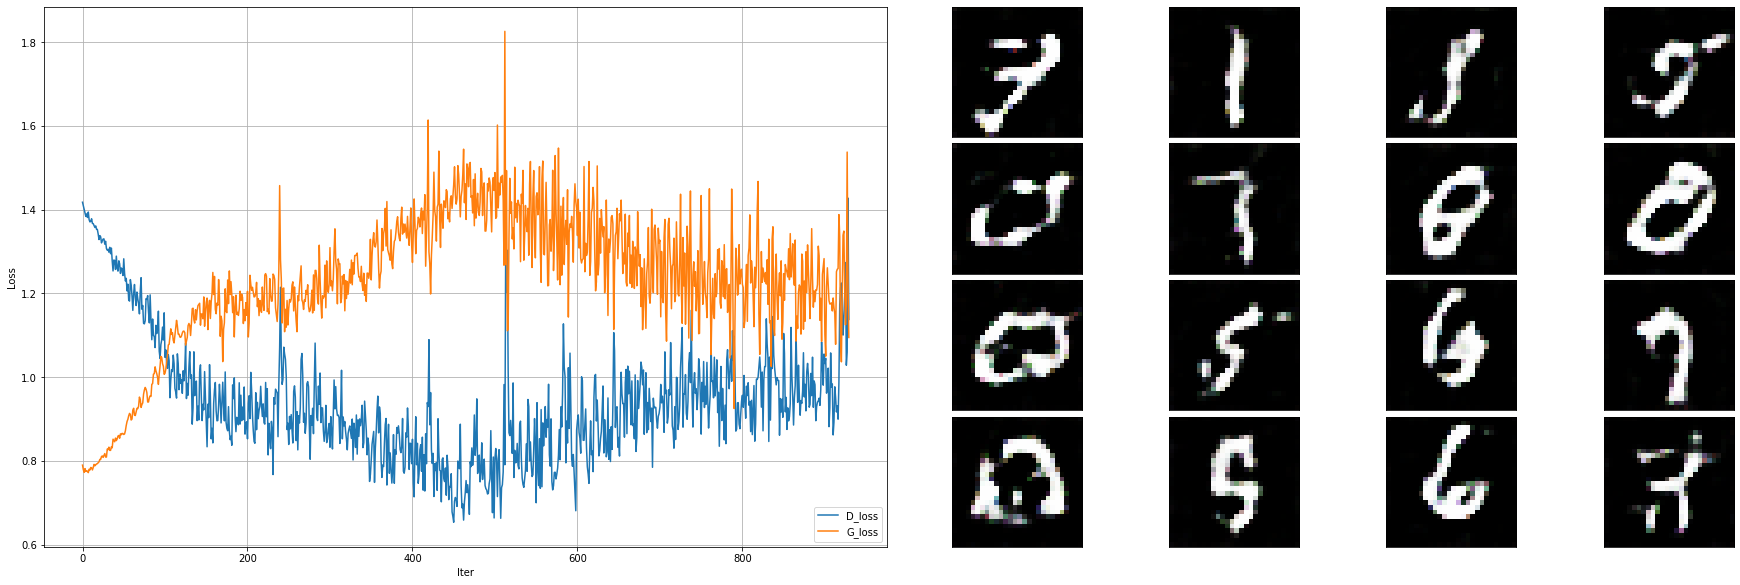

Training finish!


In [0]:
# iLect上での実行時間目安: 196秒
gan = GAN()
gan.train()

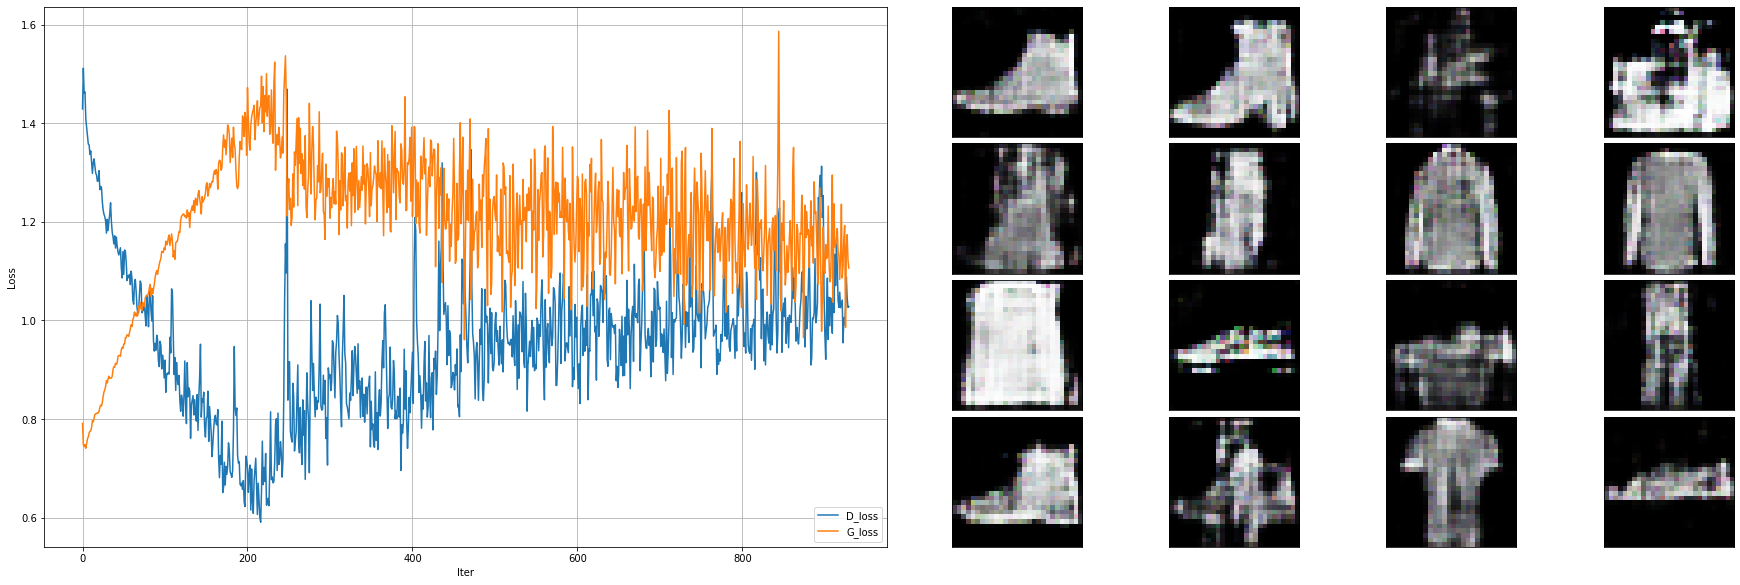

Training finish!


In [0]:
# iLect上での実行時間目安: 200秒
gan = GAN(dataset='fashion-mnist')
gan.train()

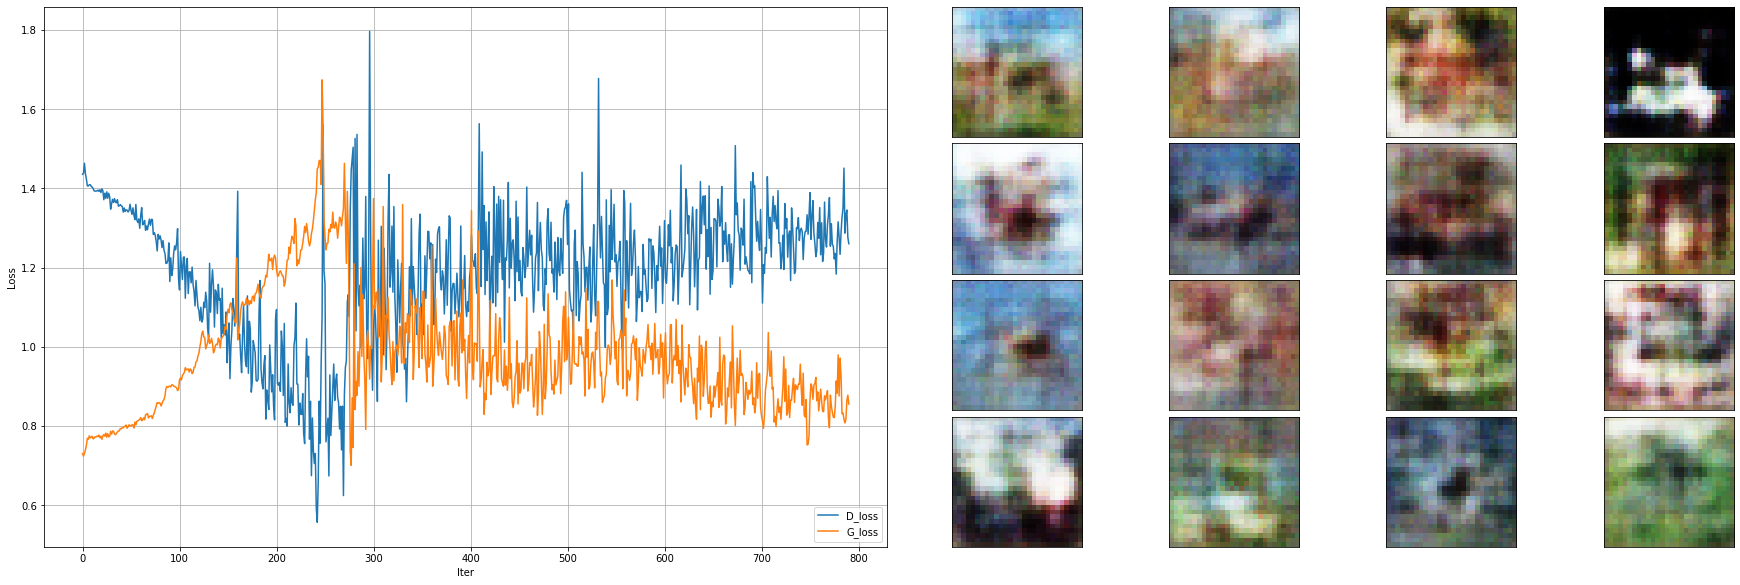

In [0]:
# iLect上での実行時間目安: 512秒
gan = GAN(dataset='cifar10', epoch=3)
gan.train()

### 3.2 LSGAN

[Least Squares Generative Adversarial Networks](https://arxiv.org/abs/1611.04076)(LSGAN)は二乗誤差を用いる手法です。3.1のGANとの違いはLSGANは損失関数を正解ラベルに対する二乗誤差としているところです。以下のような損失関数になります。

\begin{aligned} L _ { D } ^ { L S G A N } & = E \left[ ( D ( x ) - 1 ) ^ { 2 } \right] + E \left[ D ( G ( z ) ) ^ { 2 } \right] \\ L _ { G } ^ { L S G A N } & = E \left[ ( D ( G ( z ) ) - 1 ) ^ { 2 } \right] \end{aligned}

In [0]:
class LSGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 1
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.MSE_loss = nn.MSELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.MSE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.MSE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.MSE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 193秒
lsgan = LSGAN() # 他のデータセットで学習する場合: LSGAN(dataset='fashion-mnist'), LSGAN(dataset='cifar10')
lsgan.train()

### 3.3 WGAN

通常のGANはJensen-Shannonダイバージェンスを指標に確率密度間の距離を近づける学習とみなせますが勾配消失問題によって学習がうまくいかなくなることが知られています。そのため、別の指標としてWasserstein距離を用いたのが[Wasserstein GAN](https://arxiv.org/abs/1701.07875) (WGAN)です。$D(x)$がWasserstein距離として意味を持つためにはリプシッツ関数である必要があります。この制約を満たすために、パラメータをクリップしています。

\begin{aligned} L _ { D } ^ { W G A N } & = E [ D ( x ) ] - E [ D ( G ( z ) ) ] \\ L _ { G } ^ { W G A N } & = E [ D ( G ( z ) ) ] \end{aligned}

\begin{aligned}W _ { D } \leftarrow \operatorname { clip\_by\_value } \left( W _ { D } , - 0.01,0.01 \right)\end{aligned}

In [0]:
# clipping is different
class WGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 5
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.c = 0.01                   # clipping value
        self.n_critic = 5               # the number of iterations of the critic per generator iteration

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                D_loss = D_real_loss + D_fake_loss

                D_loss.backward()
                self.D_optimizer.step()

                # clipping D
                for p in self.D.parameters():
                    p.data.clamp_(-self.c, self.c) # -0.01 - 0.01

                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 809秒
wgan = WGAN()  # 他のデータセットで学習する場合: WGAN(dataset='fashion-mnist'), WGAN(dataset='cifar10')
wgan.train()

### 3.4 WGAN_GP

WGAN では制約条件を満たすために、パラメータの重みに対してクリップを行いましたが、この処理では学習が不安定になってしまいます。それを改良するために損失関数にペナルティ項を加えたものがWGAN-GPです([Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf))。最適化されたDiscriminatorでは、本物のデータと生成データの間の任意の点に対する勾配のL2ノルムが1になるという性質があります。この性質を使って、そうならない場合に制約をかけています。この制約をgradient penaltyといいます。WGAN_GPはWGANにこのgradient penaltyの項を追加したものといえます。

\begin{aligned} L _ { D } ^ { W G A N G P } & = L _ { D } ^ { W G A N } + \lambda E \left[ ( | \nabla D ( \alpha x - ( 1 - \alpha G ( z ) ) ) | - 1 ) ^ { 2 } \right] \\ L _ { G } ^ { W G A N _ { - } G P } & = L _ { G } ^ { W G A N } \end{aligned}

In [0]:
class WGAN_GP(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 10
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.lambda_ = 10
        self.n_critic = 5               # the number of iterations of the critic per generator iteration

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                alpha = alpha.cuda()

                x_hat = alpha * x_.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                             create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 1949秒
wgan_gp = WGAN_GP()  # 他のデータセットで学習する場合: WGAN_GP(dataset='fashion-mnist'), WGAN_GP(dataset='cifar10')
wgan_gp.train()

### 3.5 DRAGAN

GANの学習は、目的関数が非凸関数であるために局所的均衡点に達してmode collapseを起こしてしまうことが考えられます。[DRAGAN](https://arxiv.org/pdf/1705.07215.pdf)はこれを解決するために、訓練データ周りに観測される急勾配を緩和します。これによって、mode collapseの少ない安定した学習を実現しました。

\begin{aligned} L _ { D } ^ { D R A G A N } & = L _ { D } ^ { G A N } + \lambda E \left[ \left( \left| \nabla D \left( \alpha x - \left( 1 - \alpha x _ { p } \right) \right) \right| - 1 \right) ^ { 2 } \right] \\ L _ { G } ^ { D R A G A N } & = L _ { G } ^ { G A N } \end{aligned}

In [0]:
class DRAGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 1
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.lambda_ = 0.25

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                """ DRAGAN Loss (Gradient penalty) """
                alpha = torch.rand(self.batch_size, 1, 1, 1).cuda()
                alpha = alpha.cuda()
                x_p = x_ + 0.5 * x_.std() * torch.rand(x_.size()).cuda()
                differences = x_p - x_
                interpolates = x_ + (alpha * differences)
                interpolates.requires_grad = True
                pred_hat = self.D(interpolates)
                gradients = grad(outputs=pred_hat, inputs=interpolates, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                             create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty
                self.train_hist['D_loss'].append(D_loss.item())
                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)

                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 215秒
dragan = DRAGAN()  # 他のデータセットで学習する場合: DRAGAN(dataset='fashion-mnist'), DRAGAN(dataset='cifar10')
dragan.train()

### 3.6 EBGAN

[Energy-based Generative Adversarial Network(EBGAN) ](https://arxiv.org/pdf/1609.03126.pdf)はdiscriminatorをエネルギー関数とみなします。generatorはエネルギーが最小となるサンプルを生成するように学習しているとみなされ、discriminatorは生成されたサンプルに高エネルギーを割り当てるように学習を行います。discriminatorはautoencoderになっており、通常のGANよりも安定した動作を示します。

\begin{aligned} L _ { D } ^ { E B G A N } & = D _ { A E } ( x ) + \max \left( 0 , m - D _ { A E } ( G ( z ) ) \right) \\ L _ { G } ^ { E B G A N } & = D _ { A E } ( G ( z ) ) + \lambda \cdot P T \end{aligned}

- m: margin
- PT: pulling-away Term

In [0]:
# for ebgan
class ebgan_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(ebgan_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU(),
        )
        self.code = nn.Sequential(
            nn.Linear(64 * (self.input_size // 2) * (self.input_size // 2), 32), # bn and relu are excluded since code is used in pullaway_loss
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 64 * (self.input_size // 2) * (self.input_size // 2)),
            nn.BatchNorm1d(64 * (self.input_size // 2) * (self.input_size // 2)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            # nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.size()[0], -1)
        code = self.code(x)
        x = self.fc(code)
        x = x.view(-1, 64, (self.input_size // 2), (self.input_size // 2))
        x = self.deconv(x)

        return x, code

In [0]:
class EBGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 15
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.pt_loss_weight = 0.1
        self.margin = 1

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = ebgan_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.MSE_loss = nn.MSELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real, _ = self.D(x_)
                D_real_loss = self.MSE_loss(D_real, x_)

                G_ = self.G(z_)
                D_fake, _ = self.D(G_)
                D_fake_loss = self.MSE_loss(D_fake, G_.detach())

                D_loss = D_real_loss + torch.clamp(self.margin - D_fake_loss, min=0)
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake, D_fake_code = self.D(G_)
                D_fake_loss = self.MSE_loss(D_fake, G_.detach())
                G_loss = D_fake_loss + self.pt_loss_weight * self.pullaway_loss(D_fake_code.view(self.batch_size, -1))
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")


    def pullaway_loss(self, embeddings):
        """ pullaway_loss tensorflow version code
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
            normalized_embeddings = embeddings / norm
            similarity = tf.matmul(
                normalized_embeddings, normalized_embeddings, transpose_b=True)
            batch_size = tf.cast(tf.shape(embeddings)[0], tf.float32)
            pt_loss = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
            return pt_loss
        """
        # norm = torch.sqrt(torch.sum(embeddings ** 2, 1, keepdim=True))
        # normalized_embeddings = embeddings / norm
        # similarity = torch.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0))
        # batch_size = embeddings.size()[0]
        # pt_loss = (torch.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))

        norm = torch.norm(embeddings, 1)
        normalized_embeddings = embeddings / norm
        similarity = torch.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0)) ** 2
        batch_size = embeddings.size()[0]
        pt_loss = (torch.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))

        return pt_loss

In [0]:
# iLect上での実行時間目安: 2391秒
ebgan = EBGAN()  # 他のデータセットで学習する場合: EBGAN(dataset='fashion-mnist'), EBGAN(dataset='cifar10')
ebgan.train()

### 3.7 BEGAN

[BEGAN: Boundary Equilibrium Generative Adversarial Networks](https://arxiv.org/abs/1703.10717)はdiscriminatorがautoencoderになっており、この誤差を利用しています。訓練データの誤差と生成データの誤差のWasserstein距離を近づけるように学習を行います。

\begin{aligned} L _ { D } ^ { B E G A N } & = D _ { A E } ( x ) - k _ { t } D _ { A E } ( G ( z ) ) \\ L _ { G } ^ { B E G A N } & = D _ { A E } ( G ( z ) ) \\ k _ { t + 1 } = & k _ { t } + \lambda \left( \gamma D _ { A E } ( x ) - D _ { A E } ( G ( z ) ) \right) \end{aligned}

In [0]:
# for began
class began_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(began_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * (self.input_size // 2) * (self.input_size // 2), 32),
            nn.Linear(32, 64 * (self.input_size // 2) * (self.input_size // 2)),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            #nn.Sigmoid(),
        )

        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = x.view(-1, 64, (self.input_size // 2), (self.input_size // 2))
        x = self.deconv(x)

        return x

In [0]:
class BEGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 3
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.gamma = 1
        self.lambda_ = 0.001
        self.k = 0.0
        self.lr_lower_boundary = 0.00002
        
        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = began_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=0.0002, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=0.0002, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.M = {}
        self.M['pre'] = []
        self.M['pre'].append(1)
        self.M['cur'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))

                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = torch.mean(torch.abs(D_real - x_))

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                D_loss = D_real_loss - self.k * D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                G_loss = D_fake_loss
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                # convergence metric
                temp_M = D_real_loss + torch.abs(self.gamma * D_real_loss - G_loss)

                # operation for updating k
                temp_k = self.k + self.lambda_ * (self.gamma * D_real_loss - G_loss)
                temp_k = temp_k.item()

                self.k = min(max(temp_k, 0), 1)
                self.M['cur'] = temp_M.item()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
            # if epoch == 0:
            #     self.M['pre'] = self.M['cur']
            #     self.M['cur'] = []
            # else:
            if np.mean(self.M['pre']) < np.mean(self.M['cur']):
                pre_lr = self.G_optimizer.param_groups[0]['lr']
                self.G_optimizer.param_groups[0]['lr'] = max(self.G_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                self.D_optimizer.param_groups[0]['lr'] = max(self.D_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(
                    np.mean(self.M['cur'])) + ', lr: ' + str(pre_lr) + ' --> ' + str(
                    self.G_optimizer.param_groups[0]['lr']))
            else:
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(np.mean(self.M['cur'])))
                self.M['pre'] = self.M['cur']

                self.M['cur'] = []
                
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 496秒
began = BEGAN()  # 他のデータセットで学習する場合: BEGAN(dataset='fashion-mnist'), BEGAN(dataset='cifar10')
began.train()

### 3.8 SN(Spectral Normalization)GAN

[Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957)はDiscriminatorのの各レイヤーのスペクトルノルムを制限することで、リプシッツ定数をコントロールし、安定性を向上させた。

In [0]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = self._l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = self._l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = self._l2normalize(u.data)
        v.data = self._l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (v.norm() + eps)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [0]:
class sngan_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(sngan_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        
        self.conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(self.input_dim, 64, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 128, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 256, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            SpectralNorm(nn.Linear(256 * (self.input_size//4) * (self.input_size//4), self.output_dim)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, 256 * (self.input_size//4) * (self.input_size//4)))

        return x

In [0]:
class SNGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 3
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10
            

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = sngan_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()
                
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()
                       
        plt.close()
        print("Training finish!")

In [0]:
# iLect上での実行時間目安: 802秒
sngan = SNGAN()  # 他のデータセットで学習する場合: SNGAN(dataset='fashion-mnist'), SNGAN(dataset='cifar10')
sngan.train()